In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [2]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import clientID, clientSEC           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [3]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSEC)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [5]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,7 rings,Ariana Grande,5249057,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01,2019-01,0.036990
1,2,Sweet but Psycho,Ava Max,2874281,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,01,2019-01,0.020255
2,3,Wow.,Post Malone,2865682,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01,2019-01,0.020195
3,4,Dancing With A Stranger (with Normani),Sam Smith,2746722,https://open.spotify.com/track/6Qs4SXO9dwPj5GK...,2019,01,2019-01,0.019356
4,5,Giant (with Rag'n'Bone Man),Calvin Harris,2413175,https://open.spotify.com/track/5itOtNx0WxtJmi1...,2019,01,2019-01,0.017006
...,...,...,...,...,...,...,...,...,...
195,196,The Chain - 2004 Remaster,Fleetwood Mac,386369,https://open.spotify.com/track/5e9TFTbltYBg2xT...,2020,12,2020-12,0.002467
196,197,goosebumps,Travis Scott,386084,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002465
197,198,GO (feat. Juice WRLD),The Kid LAROI,384363,https://open.spotify.com/track/2rPHUAeUPbNgTmK...,2020,12,2020-12,0.002454
198,199,Papi Chulo,Octavian,379760,https://open.spotify.com/track/6Juv5N0dNU1imms...,2020,12,2020-12,0.002425


In [7]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)                                   # nan if nothing

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Options song ID : 1Q3HtTFGxjmEljAw7Y0CaR
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Play song ID : 4DpNNXFMMxQEKl7r0ykkWA
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
ZEZE (feat. Travis Scott & Offset) song ID : 0FZ4Dmg8jJJAPJnvBIzD9z
Lost in the Fire song ID : 2vXKRlJBXyOcvZYTdNeckS
R

Desire (with Dimension) song ID : 507UUx311ghfFTMSuHUeyS
changes song ID : 7AFASza1mXqntmGtbxXprO
bellyache song ID : 51NFxnQvaosfDDutk0tams
Fire On Fire - From "Watership Down" song ID : 5rFj8OzffT0iggSjcBaeND
A Million Dreams song ID : 0RoA7ObU6phWpqhlC9zH4Z
Feel It Still song ID : 6QgjcU0zLnzq5OrUoSZ3OK
Jackie Chan song ID : 4kWO6O1BUXcZmaxitpVUwp
Unforgettable song ID : 3B54sVLJ402zGa6Xm4YGNe
Wake Up in the Sky song ID : 0QIjsbm2fh1cJ45XO9eGqq
Under Pressure - Remastered 2011 song ID : 11IzgLRXV7Cgek3tEgGgjw
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
i apologise if you feel something song ID : 4mrjzz6ETpW3wosJUYmKoL
First Off (feat. Travis Scott) song ID : 3WRIaWsws011vHMd9uzPjG
Budapest song ID : 2ixsaeFioXJmMgkkbd4uj1
Do I Wanna Know? song ID : 5FVd6KXrgO9B3JPmC8OPst
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Survival of the Fittest song ID : 7N1Vjtzr1lmmCW9iasQ8YO
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Lucky You (feat. Joyner Lucas) song ID : 6

Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
Never Enough song ID : 0Gl5s8IhMmQE5YQwM8Qx1J
Desire (with Dimension) song ID : 507UUx311ghfFTMSuHUeyS
If You're Over Me song ID : 01k24g94i1JvkFLQmVEdCd
These Days (feat. Jess Glynne, Macklemore & Dan Caplen) song ID : 5CLGzJsGqhCEECcpnFQA8x
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Praise The Lord (Da Shine) (feat. Skepta) song ID : 7ycWLEP1GsNjVvcjawXz3z
Sincerity Is Scary song ID : 6HguG9HRb1Ke1bhihfE4m8
Money song ID : 2GGMabyHXnJmjY6CXhhB2e
Con Calma song ID : 6blCIq6wN3uK65sIfG4dP1
Think About You song ID : 3Kuu5vASpXK8oRsxOvau6P
Pumpy (feat. Deno, Cadet, AJ & Swarmz) song ID : 2r7kFZo4Ua517FKCW39fo9
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Needed Time song ID : 1k65BavLispRXs7vzBuRLV
Rise song ID : 69Sy7207dnixZ6w7RSV9Kb
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
The Other Side song ID : 2cKovq3l6OJjhVVDbVKOsr
Shape of You song ID : 7qiZfU

Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Last Hurrah song ID : 0i0wnv9UoFdZ5MfuFGQzMy
Bally song ID : 0x0oAe2AqvzQmjTtpO5DCd
Nice For What song ID : 3CA9pLiwRIGtUBiMjbZmRw
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Almost (Sweet Music) song ID : 5Apvsk0suoivI1H8CmBglv
Let You Love Me song ID : 5Fla3zyOCcIRqrDoKLU0DP
Con Calma song ID : 6blCIq6wN3uK65sIfG4dP1
R.I.P. (feat. Rita Ora & Anitta) song ID : 6JqpFboOH2bq9pzaYbkKBn
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
Fast song ID : 6MjNilJCVKJq0LfFvo5jWJ
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
Ruin My Life song ID : 5tAa8Uaqr4VvA3693mbIhU
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
BABY song ID : 6epn3r7S14KUqlReYr77hA
Just Got Paid song ID : 0v3BMLcwUmAwyqJaf5997o
I'll Be There song ID : 4r1CoAATVuxag55Ct3Y1aX
Back & Forth song ID : 45wneA2j0Z0WMnYNDO6Ad0
The Greatest Show song ID : 4ylWMuGbMXNDgDd8lErEle
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Hello My Love

thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Grace song ID : 01JMnRUs2YOK6DDpdQASGY
Power is Power song ID : 4cbdPT6uaBOgOQe3fLMofl
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Nobody song ID : 6bTn1ovliI0OkjUNkiMBJq
my strange addiction song ID : 3Tc57t9l2O8FwQZtQOvPXK
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Advice song ID : 2XwcKJW9Q0gaDIZzg0dKQt
you should see me in a crown song ID : 3XF5xLJHOQQRbWya6hBp7d
Earth song ID : 2S1LebN6AXXQqJolBxlWgO
Sixteen song ID : 3pJkBPHadRAxBBo484RipI
Daily Duppy (feat. GRM Daily) song ID : 65VcwXOF7IR5YMXGNhfXQI
Kitchen Kings song ID : 1RJHieKAxYz9qbREvOR5eA
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
lovely song ID : 0u2P5u6lvoDfwTYjAADbn4
Carry On (from the Original Motion Picture "POKÉMON Detective Pikachu") song ID : 3y3brCCecHC3Db18aIOnny
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Please Me song ID : 0PG9fbaaHFHfre2gUVo7AN
all the good girls go t

Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Hold Me While You Wait song ID : 60iSKGrGazRzICtMjADNSM
SOS song ID : 30cSNer6TV8x2utjULVeQ5
If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
Location (feat. Burna Boy) song ID : 3z4CGd63tpUn9a6oQSG0CI
All Day And Night - Jax Jones & Martin Solveig Present Europa song ID : 4gMC0JNQITGa8wfTFsPu3f
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Grace song ID : 01JMnRUs2YOK6DDpdQASGY
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
Sixteen song ID : 3pJkBPHadRAxBBo484RipI
OT Bop song ID : 6bAirj2qDf0agxdMuIdq1p
What I Like About You (feat. Theresa Rex) song ID : 4NSW0Km5ZG60L8FthUebPJ
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAE

Don't Go Breaking My Heart song ID : 7HW5WIw7ZgZORCzUxv5gW5
Hold My Girl song ID : 42bbDWZ8WmXTH7PkYAlGLu
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Don't Look Back in Anger - Remastered song ID : 12dU3vAh6AFoJkisorfoUl
If You're Over Me song ID : 01k24g94i1JvkFLQmVEdCd
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
RUNNING OUT OF TIME song ID : 5QvBXUm5MglLJ3iBfTX2Wo
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Blame It on Your Love (feat. Lizzo) song ID : 1MfuskV4ODUp14C2dnyPgW
Pure Water (with Migos) song ID : 3j84U36KvLeXNDPv4t5pI8
Budapest song ID : 2ixsaeFioXJmMgkkbd4uj1
Party In The U.S.A. song ID : 5Q0Nhxo0l2bP3pNjpGJwV1
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
I Like It song ID : 58q2HKrzhC3ozto2nDdN4z
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
no tears left to cry song ID : 2qT1uLXPVPzGgFOx4jtEuo
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Power is Power (feat. The Weeknd & Travis Scott) song ID : 4cbdPT6uaBOgOQe3fLMofl
Go Your Own Way -

Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Miss Diva (feat. Yungen) song ID : 3mTSAVBL7yd7iHAaglXUPY
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Hollywood song ID : 7sWRlDoTDX8geTR8zzr2vt
Stay (Don't Go Away) [feat. Raye] song ID : 4YhN72dRYL2Z3MsaKyT7rS
Advice song ID : 2XwcKJW9Q0gaDIZzg0dKQt
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Butterflies (feat. Not3s) song ID : 4hGsbyf3p0U5mlJTJwiUTq
Sanctuary song ID : 3xaugmCyXrVkrDTXbFkMW3
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
Nice For What song ID : 3CA9pLiwRIGtUBiMjbZmRw
Don’t Feel Like Crying song ID : 1ABvDz0JnQGO8M8NYjRNMp
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
All the Time song ID : 0USZx50eApN045zIIyjePN
Everywhere - 2017 Remaster song ID : 254bXAqt3zP6P50BdQvEsq
Phone Down song ID : 5bvNpG6wiIEf1PA13TkTu2
Wanting song ID : 1KoPjPDd5cBjykLirqQDXm
Africa song ID : 2374M0fQpWi3dLnB54qaLX
Drive By song ID : 0KAiuUOrLTIkzkpfpn9jb9
Mayb

Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Way To Break My Heart (feat. Skrillex) song ID : 5d1rmWWF1725tnYjq6rMDB
Mother's Daughter song ID : 2WyRfGeHo97VC5mP1BBSzr
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Funky Friday song ID : 01IQ4aQgOf0Kkq3a273hmO
Kilos (feat. Aitch) song ID : 2LA9gKY5t2kx4BY5GSy3Us
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Sorry song ID : 7gvd8xj4QgPqbQSsn5pV7d
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Love of My Life (feat. Not3s & Young Adz) song ID : 3wPTI3G39TG3kxR5ybhrzK
Bounce Back song ID : 0SGkqnVQo9KPytSri1H6cF
Just You and I song ID : 03x2rVJRFUrvwlfxoHd9Mo
Rich (feat. D Block Europe & Offset) song ID : 0YTXcXihG2qpxb3U3LbPfc
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
MOOD 4 EVA (feat. Oumou Sangaré) song ID : 7oqftogUN82Q7VNy2TmTJW
Your Mrs song ID : 5gDQm47YjTJkdkTnfNFRMC
Boasty (feat. Idris Elba) song ID : 7cz506PyIgh2bMN90Mc8Tn
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4J

Cruel Summer song ID : 1BxfuPKGuaTgP7aM0Bbdwr
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
Outnumbered song ID : 6UjZ2Yx2g2a52XxiA8ONxZ
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
I Forgot That You Existed song ID : 43rA71bccXFGD4C8GOpIlN
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
London Boy song ID : 1LLXZFeAHK9R4xUramtUKw
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Take Me Back To London (Remix) [feat. Stormzy, Jaykae & Aitch] song ID : 2nyTaLu3TTrSS6CAxR3z0b
fuck, i'm lonely song ID : 09PGubKAMryhOWv1LHpCYz
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
South of the Border (feat. Camila Cabello & Cardi B) song ID : 4vUmTMuQqjdnvlZmAH61Qk
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Paper Rings song ID : 4y5bvROuBDPr5fuwXbIBZR
Ritual song ID : 3M9Apu4OZfylLTFKvgEtKa
Thiago Silva song ID : 3DKCTIiJ97bS9TGiqcABjo
Crown song ID : 0EmYZZ8OqeALedVhijSjsg
Never Really Over song ID : 5PYQUBXc7NYeI1obMKS

This Is Me song ID : 45aBsnKRWUzhwbcqOJLwfe
I Wanna Dance with Somebody (Who Loves Me) song ID : 2tUBqZG2AbRi7Q0BIrVrEj
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Be Someone song ID : 4esEsg9IxiTAGMBQLe9XOu
Castle on the Hill song ID : 6PCUP3dWmTjcTtXY02oFdT
Sixteen song ID : 3pJkBPHadRAxBBo484RipI
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
F.N song ID : 0RLLvYBopDwooCyvnTwgYu
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
I'm Yours song ID : 1EzrEOXmMH3G43AXT1y7pA
Put It All on Me (feat. Ella Mai) song ID : 5T03itPFOPGGkvVPvPiyla
Taste (Make It Shake) song ID : 1xPpYbCaJWonL7IFXPDjON
Ladbroke Grove song ID : 7b4ky1LlQLFhXHmhZkFgqV
Strike a Pose (feat. Aitch) song ID : 23GvTfcGK454ppLsts3W44
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Sorry song ID : 7gvd8xj4QgPqbQSsn5pV7d
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Ransom song ID : 1lOe9qE0vR9zwWQAO

Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Streatham song ID : 59PUOc7B0WCNNx8Nr4qaA4
Did It Again song ID : 4guBZjUyrGoHsTahO3IHdj
Swervin (feat. 6ix9ine) song ID : 1wJRveJZLSb1rjhnUHQiv6
Everywhere - 2017 Remaster song ID : 254bXAqt3zP6P50BdQvEsq
F.N song ID : 0RLLvYBopDwooCyvnTwgYu
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
Africa song ID : 2374M0fQpWi3dLnB54qaLX
Go Your Own Way - 2004 Remaster song ID : 4xh7W7tlNMIczFhupCPniY
break up with your girlfriend, i'm bored song ID : 4kV4N9D1iKVxx1KLvtTpjS
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
Best Life song ID : 00B7TZ0Xawar6NZ00JFomN
Pop Out (feat. Lil Tjay) song ID : 6uFn47ACjqYkc0jADwEdj1
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Dancing in the Moonlight song ID : 0q21FNwES2bbtcduB6kjEU
223's (feat. 9lokknine) song ID : 4sjiIpEv617LDXaidKioOI
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Paradise song ID : 0Rx0DJI556Ix5gBny

Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Good Thing (with Kehlani) song ID : 5aUSEPNd3m5xliFK4pn5mU
Face to Face song ID : 0YdIIMb2MHuxoUudkAY9gS
Hate Me (with Juice WRLD) song ID : 6kls8cSlUyHW2BUOkDJIZE
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Nookie song ID : 1TEZWG1FdjzDdercCguTwj
Saint-Tropez song ID : 05mDaV9Vb3wrzjF6OPZnhq
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
Guten Tag song ID : 0SErNy2An0gCpYFRUNWwNT
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
F.N song ID : 0RLLvYBopDwooCyvnTwgYu
Hollywood's Bleeding song ID : 7sWRlDoTDX8geTR8zzr2vt
Castles song ID : 3qebSLgUwaEqbwCM5sj5Kh
Lonely song ID : 4y4spB9m0Q6026KfkAvy9Q
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Come Thru (with Usher) song ID : 3TTMUI5dFcbeNSDTTDY9M8
Somebody song ID : 4wCmqSrbyCgxEXROQE6vtV
thank u, next song ID : 3e9HZxeyfWwjeyPAMmW

Better Half of Me song ID : 114xcQz8sZ6fxRBTZmgmNE
So High (feat. Fredo) song ID : 5aubXDnDNVKA5pS7EnR0mp
Rockin' Around The Christmas Tree song ID : 2EjXfH91m7f8HiJN1yQg97
10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
Fairytale of New York (feat. Kirsty MacColl) song ID : 3VTNVsTTu05dmTsVFrmGpK
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
We Got Love song ID : 35mMXfym6C9VOTUVrcKKZp
Up All Night song ID : 1mpD5Q8IM32I4bF6eCpU74
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
Do They Know It's Christmas? - 1984 Version song ID : 0247StOpd3AkeBQzANX4Zf
Post Malone (feat. RANI) song ID : 0qc4QlcCxVTGyShurEv1UU
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Grace song ID : 01JMnRUs2YOK6DDpdQASGY
Into the Unknown song ID : 3Z0oQ8r78OUaHvGPiDBR3W
Look At Her Now song ID : 7eOkHIcaoUhngxxypM5Ajr
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Floss (feat. MoStack & Not3s) song ID : 0LjXPuuttcYpND3IxAFww1
Goodbyes (Feat. Young Thug) song

ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet) song ID : 4kKdvXD0ez7jp1296JmAts
One More Sleep song ID : 78pn8k7RogKo2oxl0DyX6d
Feliz Navidad song ID : 0oPdaY4dXtc3ZsaG17V972
Sleigh Ride song ID : 5ASM6Qjiav2xPe7gRkQMsQ
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
Mistletoe song ID : 7xapw9Oy21WpfEcib2ErSA
White Christmas song ID : 4so0Wek9Ig1p6CRCHuINwW
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Let It Snow! Let It Snow! Let It Snow! song ID : 2uFaJJtFpPDc5Pa95XzTvg
The Christmas Song (Merry Christmas To You) song ID : 4PS1e8f2LvuTFgUs1Cn3ON
I Wish It Could Be Christmas Everyday song ID : 1mH6tZC6iXIHPI6EixCwxw
Merry Xmas Everybody song ID : 4dBQWyoZmmgvFBlALGlqZi
Have Yourself A Merry Little Christmas song ID : 2icrdLtKfqwZ8VUUyZbGFI
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Santa Baby song ID : 1vZKP9XURuqMp1SpXGnoyb
Santa Claus Is Comi

Better Half of Me song ID : 114xcQz8sZ6fxRBTZmgmNE
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Superheroes song ID : 37sINbJZcFdHFAsVNsPq1i
White Christmas - Spotify Singles - Holiday, Recorded at Air Studios, London song ID : 7F9oCEKbqjN99cV5HpvYER
God Is A Dancer (with Mabel) song ID : 6fenHIxXuuzKB55wY4WCHP
One Second (feat. H.E.R.) song ID : 2DdI0KRBuxV5Km0bkm67yh
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Big Michael song ID : 4zrQ9UIhPD6lL6VBISJ5aE
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Futsal Shuffle 2020 song ID : 2Ec33AVlkTTq8BHFgBTdQs
Christmas Time song ID : 299lFlaAsNQdgbIZNPmIA0
Winter Wonderland song ID : 2IuUMx3uxxJAHcH41aYtn0
When a Child Is Born song ID : 1QZWQNbo6aupLs38M2M1bY
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
Both song ID : 5tFep7dXGd7vEJ668wTPux
O Holy Night song ID : 1ORPLRGHV9lRc5zs11KBUB
LOYAL (feat. Drake) song ID : 3LnJM1B5Mjgx5LfT9plXUU
French Kisses (feat. Aitch) song ID : 2jTBEuS8P9ZqVos

Stepdad song ID : 3QVHSV8YKYq4L8tI5rnFgj
Lock It Up (feat. Anderson .Paak) song ID : 1qwMkkRiD5jqLeUUjfgblh
Marsh song ID : 2Y0wPrPQBrGhoLn14xRYCG
Down Like That (feat. Rick Ross, Lil Baby & S-X) song ID : 4etKC4ngPKsQDHUMnYgV3A
Be Honest song ID : 5pAbCxt9e3f81lOmjIXwzd
Outnumbered song ID : 6UjZ2Yx2g2a52XxiA8ONxZ
Me & You Together Song song ID : 4AQzk2yNWKs6sYhZi6NzVN
Thiago Silva song ID : 3DKCTIiJ97bS9TGiqcABjo
Blow Off My Cover song ID : 4YkxRf7jaNHJYdLWiF1mnG
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Yah Yah (feat. Royce Da 5'9", Black Thought, Q-Tip & Denaun) song ID : 5mZXWEH2eh8zMZGCxT5aW0
Faith In My Killy (feat. Nafe Smallz, Yxng Bane, Blade Brown and Skrapz) song ID : 7aIFQj5W8Q2Rg8ggde8BLc
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Premonition - Intro song ID : 7ccTcabbJlCJiIqtrSSwBk
French Kisses (feat. Aitch) song ID : 2jTBEuS8P9ZqVos9zecRzl
Savage song ID : 55CHeLEfn5iJ0IIkgaa4si
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Old Town Road - Remix song ID : 2YpeDb67231RjR0

ON song ID : 4Iedi94TIaB2GGb1nMB68v
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
What If I Told You That I Love You song ID : 74D7JUfU6HYeMx4bZhsHnG
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
Birthday song ID : 4NpDZPwSXmL0cCTaJuVrCw
Pee Pee song ID : 5iwXbChKtH2OB6a1fxmp7R
The Birthday Party song ID : 3wFPsw1WQJevCFoKpoLyTF
Good as Hell (feat. Ariana Grande) song ID : 07Oz5StQ7GRoygNLaXs2pd
Tequila - Jax Jones & Martin Solveig Present Europa song ID : 6fU55C7VdMSSkJ0ZGmX2Kg
Destined For Greatness song ID : 2NlDF79eSeqe5FwmoVNdnG
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
Feel Me song ID : 6XXYdF6pJR1K3wKvuxmu7n
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Repeat (feat. Koffee) song ID : 6Yblv6BbZHIkyrpYl4E0Zk
Grace song ID : 01JMnRUs2YOK6DDpdQASGY
Sorry song ID : 7gvd8xj4QgPqbQSsn5pV7d
ON (Feat. Sia) song ID : 3IB5qOeMayvpOdHxYCL5tZ
BOP song ID : 6Ozh9Ok6h4Oi1wUSLtBseN
No Idea song ID : 7AzlLxHn24Dxjg

Know Your Worth song ID : 0TrPqhAMoaKUFLR7iYDokf
Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
No Judgement song ID : 5IUOU5xkzGHsRFOYNu3GSK
Flowers (feat. Jaykae and MALIKA) song ID : 5aYWnrsYvJk8NT7PmUcxVN
To Die For song ID : 2ZTYlnhhV1UAReg7wIGolx
Skechers song ID : 2alc8VZAzDgdAsL2QMk3hu
The Take (feat. Chris Brown) song ID : 0Odu228D0yGcFySGuxU4rY
Location (feat. Burna Boy) song ID : 3z4CGd63tpUn9a6oQSG0CI
Ladbroke Grove song ID : 7b4ky1LlQLFhXHmhZkFgqV
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
War song ID : 64SCQtbRtmO28ks1QhS3w5
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Play Play (feat. Burna Boy) song ID : 3R60ekRcGXuaoZmnbdlf3n
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Vossi Bop song ID : 44ZJ4hLD5onikKsVLQaILr
Savage song ID : 55CHeLEfn5iJ0IIkgaa4si
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Self-Obsessed (feat. Krept & Konan, D-Block Europe & Deno) song ID : 6n5bMUstoBB10NOOWlv20k
High Fashion (feat. Mustard) song ID : 07K

Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Say So song ID : 3Dv1eDb0MEgF93GpLXlucZ
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Rain song ID : 24ySl2hOPGCDcxBxFIqWBu
Rover (feat. DTG) song ID : 4slSrbTK1sNK4I1mDYEthf
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Righteous song ID : 5dOxHHMOFAbG3VH23t0xNm
Lonely song ID : 4y4spB9m0Q6026KfkAvy9Q
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Flowers (feat. Jaykae and MALIKA) song ID : 5aYWnrsYvJk8NT7PmUcxVN
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Savage song ID : 55CHeLEfn5iJ0IIkgaa4si
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
If You’re Too Shy (Let Me Know) - Edi

Poppin (feat. Lil Pump & Smokepurpp) song ID : 7x6t40pKRU1h9fFx7124wf
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Do I Wanna Know? song ID : 5FVd6KXrgO9B3JPmC8OPst
No Idea song ID : 7AzlLxHn24DxjgQX73F9fU
Options song ID : 1Q3HtTFGxjmEljAw7Y0CaR
Suicidal song ID : 1iSqfoUFnQwV0QW1EfUit8
Wait a Minute! song ID : 0y60itmpH0aPKsFiGxmtnh
Dancing On My Own song ID : 2BOqDYLOJBiMOXShCV1neZ
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
She Moves In Her Own Way song ID : 2SGBEDwsOAOAHrrdAd304i
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
Wake Me Up song ID : 0nrRP2bk19rLc0orkWPQk2
Down Like That (feat. Rick Ross, Lil Baby & S-X) song ID : 4etKC4ngPKsQDHUMnYgV3A
P2 song ID : 3kW4z2pIj5VY5fLjBrMRL5
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Lose You

Hickory Dickory Dock song ID : 2jDL6ctWUV1WoGC9I2MRNW
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
Roadkill song ID : 2ymCaPd4ojF9H8hzIz2NJd
Skechers song ID : 2alc8VZAzDgdAsL2QMk3hu
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Me & You Together Song song ID : 4AQzk2yNWKs6sYhZi6NzVN
Level of Concern song ID : 6xZ4Q2k2ompmDppyeESIY8
Wonderwall - Remastered song ID : 7ygpwy2qP3NbrxVkHvUhXY
Can't Hold Us - feat. Ray Dalton song ID : 3bidbhpOYeV4knp8AIu8Xn
I Think There's Something You Should Know song ID : 3mRWkQTwau3cl5u2WYE2pt
Mr. Blue Sky song ID : 2RlgNHKcydI9sayD2Df2xp
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
WUNNA song ID : 0y7Ao3CVJsyKFmqdjutiIF
Walk Em Down (feat. Roddy Ricch) song ID : 4cSSL3YafYjM3yjgFO1vJg
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
One Kiss (with Dua Lipa) song ID : 7ef4DlsgrMEH11cDZd32M6
No Judgement song ID : 5IUOU5xkzGHsRFOYNu3GSK
Dancing In The Moonlight (feat. NEIMY) song ID : 4GSDkZt7Gcmz

Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Dancing In The Moonlight (feat. NEIMY) song ID : 4GSDkZt7GcmzBWmsMcpaVO
Be Kind (with Halsey) song ID : 3Z8FwOEN59mRMxDCtb8N0A
Vossi Bop song ID : 44ZJ4hLD5onikKsVLQaILr
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Strike a Pose (feat. Aitch) song ID : 23GvTfcGK454ppLsts3W44
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Tommy Lee (feat. Post Malone) song ID : 5QZKcQDp0tCcvMdyqEciBV
Free 22 song ID : 0oS2O93E2VLWwIyigtc8Ci
Señorita song ID : 0TK2YIli7K1leLovkQiNik
So

death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
epiphany song ID : 08fa9LFcFBTcilB3iq2e2A
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
Rain song ID : 24ySl2hOPGCDcxBxFIqWBu
Flowers (feat. Jaykae and MALIKA) song ID : 5aYWnrsYvJk8NT7PmUcxVN
peace song ID : 7MbT4I8qGntX4fMdqMQgke
WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil Wayne) - Remix song ID : 2MbdDtCv5LUVjYy9RuGTgC
Woi song ID : 69F4G9WD5U1vKrpaCiLznl
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Who's That What's That song ID : 6pRlNmiZ15mI0D0Y9VBjDe
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
hoax song ID : 6MWoRt97mnSTXZhu3ggi9C
Holiday song ID : 6zFMeegAMYQo0mt8rXtrli
Chicago Freestyle (feat. Giveon) song ID : 4wVOKKEHUJxHCFFNUWDn0B
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Ego Death (feat. Kanye West, FKA twigs & Skrillex) song ID : 3Q5cLvkKsHJvYltf8k7HkO
This City song ID : 3H3r2nKWa3Yk5gt8xgmsEt
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
F

What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Both song ID : 5tFep7dXGd7vEJ668wTPux
Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
Naive song ID : 2RUhtNBh43RtSg0WBPPq3m
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
WAP (feat. Megan Thee Stallion) song ID : 4Oun2ylbjFKMPTiaSbbCih
Head & Heart (feat. MNEK) song ID : 6cx06DFPPHchuUAcTxznu9
Ain't It Different (feat. AJ Tracey & Stormzy) song ID : 6NJfIydBMYrXvlaXsFxmc8
Laugh Now Cry Later (feat. Lil Durk) song ID : 2SAqBLGA283SUiwJ3xOUVI
Lighter (feat. KSI) song ID : 5lWUeSYO61UYgNlFlqcwYl
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
West Ten song ID : 33EGYJLLwz56YIP5Ex9VKs
GREECE (feat. Drake) song ID : 35RJhm1pEovTBwnNR0zWad
Watermelon Sugar song ID : 6UelLqGlWMcVH1E

Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Enjoy Yourself (feat. Karol G) song ID : 3NWrHCwvyII4fTx05PN3IO
Mr. Blue Sky song ID : 2RlgNHKcydI9sayD2Df2xp
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
I Wanna Dance with Somebody (Who Loves Me) song ID : 2tUBqZG2AbRi7Q0BIrVrEj
Everywhere - 2017 Remaster song ID : 254bXAqt3zP6P50BdQvEsq
TWIST & TURN (feat. Drake & PARTYNEXTDOOR) song ID : 24SDeYAeTFda8OUzVI1VR6
After Party song ID : 527k23H0A4Q0UJN3vGs0Da
Thiago Silva song ID : 3DKCTIiJ97bS9TGiqcABjo
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
21 song ID : 3JKgcAa7r07ocVWcV8bS0H
The Less I Know The Better song ID : 6K4t31amVTZDgR3sKmwUJJ
Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Believer song ID : 0pqnGHJpmpxLKifKRm

Do I Wanna Know? song ID : 5FVd6KXrgO9B3JPmC8OPst
Wonderwall - Remastered song ID : 7ygpwy2qP3NbrxVkHvUhXY
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Vossi Bop song ID : 44ZJ4hLD5onikKsVLQaILr
Hello (feat. A Boogie Wit da Hoodie) song ID : 2r6OAV3WsYtXuXjvJ1lIDi
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Something Special song ID : 5kkaSMcf4BFlhRRICCKZb6
Burning (feat. M Huncho & Dutchavelli) song ID : 3fAa5d2KhtXJ1gxB1wobQz
Are You Bored Yet? (feat. Clairo) song ID : 57RA3JGafJm5zRtKJiKPIm
See Nobody song ID : 68rEUVTZCTJXbTibKFGqNS
You Got It song ID : 4lsHZ92XCFOQfzJFBTluk8
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Mad at Disney song ID : 7aGyRfJWtLqgJaZoG9lJhE
Someone To You song ID : 14BH4qO7pgCmIe6mgLKOK3
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Hold Me While You Wait song

Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Teardrops song ID : 3aniWcwiiYKHpm3F5TdeKD
Come Over (feat. Anne-Marie & Tion Wayne) song ID : 4eVU4U063iMLFJFXb9kzkb
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Papi Chulo song ID : 6Juv5N0dNU1imms9c9u1dA
Location (feat. Burna Boy) song ID : 3z4CGd63tpUn9a6oQSG0CI
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
808 (feat. dutchavelli, DigDat & B Young) song ID : 4MrXtliOu0PA3pWVdkA94h
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Heaven On My Mind (with Sigala) song ID : 7bIq1v8svANsAys7I694Up
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
Loading song ID : 4D0GT8zWuA7Z2em6dpajAn
Heart Of Glass (Live from the iHeart Festival) song ID : 5i7ThJfYLAzp2DyZuFpF6j
Rain song ID : 24ySl2hOPGCDcxBxFIqWBu
Woi song ID : 69F4G9WD5U1vKrpaCiLznl
Only You Freestyle song ID : 4OENnoidV0h8gJV6bhrw7r
Loose (feat. KSI) song ID : 0G9vbgmLrDqjV4NUCSrsIg
death bed (co

WAP (feat. Megan Thee Stallion) song ID : 4Oun2ylbjFKMPTiaSbbCih
Really Love (feat. Craig David & Digital Farm Animals) song ID : 50v2TSRV31bwpAPkjWejNL
Rockin' Around The Christmas Tree song ID : 2EjXfH91m7f8HiJN1yQg97
Monster (Shawn Mendes & Justin Bieber) song ID : 2Z8yfpFX0ZMavHkcIeHiO1
Ain't It Different (feat. AJ Tracey & Stormzy) song ID : 6NJfIydBMYrXvlaXsFxmc8
pov song ID : 3UoULw70kMsiVXxW0L3A33
Holy (feat. Chance The Rapper) song ID : 5u1n1kITHCxxp8twBcZxWy
Looking for Me song ID : 5dvGLnXYsBUQLAmJHBYgrN
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Midnight Sky song ID : 27ycaQnQAxaPiyeg3nr2aB
For The Night (feat. Lil Baby & DaBaby) song ID : 0PvFJmanyNQMseIFrU708S
Paradise (feat. Dermot Kennedy) song ID : 6ft4hAq6yde8jPZY2i5zLr
Underneath the Tree song ID : 3YZE5qDV7u1ZD1gZc47ZeR
Fairytale of New York (feat. Kirsty MacColl) song ID : 3VTNVsTTu05dmTsVFrmGpK
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
Lonely (wit

Smile (with The Weeknd) song ID : 6wQlQrTY5mVS8EGaFZVwVF
Stay song ID : 4H7WNRErSbONkM06blBoGc
Kate Winslet (feat. Unknown T) song ID : 1QPIsbNZiuDv9NBjvkZYNU
No Role Modelz song ID : 62vpWI1CHwFy7tMIcSStl8
When The Sun Goes Down song ID : 5vLonpxn4VN0A8GtQOBSG0
I Wanna Dance with Somebody (Who Loves Me) song ID : 2tUBqZG2AbRi7Q0BIrVrEj
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Hello (feat. A Boogie Wit da Hoodie) song ID : 2r6OAV3WsYtXuXjvJ1lIDi
Star Shopping song ID : 30bqVoKjX479ab90a8Pafp
Fluorescent Adolescent song ID : 7e8utCy2JlSB8dRHKi49xM
Chicago Freestyle (feat. Giveon) song ID : 4wVOKKEHUJxHCFFNUWDn0B
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Heart Of Glass (Live from the iHeart Festival) song ID : 5i7ThJfYLAzp2DyZuFpF6j
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Loose (feat. KSI) song ID : 0G9vbgmLrDqjV4NUCSrsIg
E-GIRLS ARE RUINING MY LIFE! song ID : 7bCfHiRcfUjG0YVVNUL7Ve
Vossi Bop song ID : 44ZJ4hLD5onikKsVLQaILr
Stuck w

Godzilla (feat. Juice WRLD) song ID : 7FIWs0pqAYbP91WWM0vlTQ
Santa Baby (with Henri René & His Orchestra) song ID : 1foCxQtxBweJtZmdxhEHVO
Goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
UFO song ID : 3Hbwbuk3ChdUf7M6Cn7uQB
Giants song ID : 0l4AReW2LuX0yStPfgQgSR
Go Crazy song ID : 1IIKrJVP1C9N7iPtG6eOsK
Lonely (with benny blanco) song ID : 4y4spB9m0Q6026KfkAvy9Q
Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
I Wanna Dance with Somebody (Who Loves Me) song ID : 2tUBqZG2AbRi7Q0BIrVrEj
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Naughty List (with Dixie D’Amelio) song ID : 2Y0ktCGrGoGcQFXsGztvhi
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Come & Go (with Marshmello) song ID : 2Y0wPrPQBrGhoLn14xRYCG
Merry Christmas Baby song ID : 2dbfjsBbi3nt0a173iUumA
Good Days song ID : 3YJJjQPAbDT7mGpX3WtQ9A
Daisy song ID : 0AUvWawuP0ibk4SQ3sIZjk
Show Out (with Skepta & Pop Smoke) song ID : 5CFJRZRq6sdKKtRwNPWbYv
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
i miss u (with Au/Ra)

TIP: for this next section, add an "output_files" subfolder to export into. 

In [8]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [9]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [10]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,7 rings,Ariana Grande,5249057,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.036990,6ocbgoVGwYJhOv1GgI9NsF
1,2,Sweet but Psycho,Ava Max,2874281,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.020255,7DnAm9FOTWE3cUvso43HhI
2,3,Wow.,Post Malone,2865682,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020195,7xQAfvXzm3AkraOtGPWIZg
3,4,Dancing With A Stranger (with Normani),Sam Smith,2746722,https://open.spotify.com/track/6Qs4SXO9dwPj5GK...,2019,1,2019-01,0.019356,6Qs4SXO9dwPj5GKvVOv8Ki
4,5,Giant (with Rag'n'Bone Man),Calvin Harris,2413175,https://open.spotify.com/track/5itOtNx0WxtJmi1...,2019,1,2019-01,0.017006,5itOtNx0WxtJmi1TQ3RuRd
...,...,...,...,...,...,...,...,...,...,...
4771,196,The Chain - 2004 Remaster,Fleetwood Mac,386369,https://open.spotify.com/track/5e9TFTbltYBg2xT...,2020,12,2020-12,0.002467,5e9TFTbltYBg2xThimr0rU
4772,197,goosebumps,Travis Scott,386084,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002465,6gBFPUFcJLzWGx4lenP6h2
4773,198,GO (feat. Juice WRLD),The Kid LAROI,384363,https://open.spotify.com/track/2rPHUAeUPbNgTmK...,2020,12,2020-12,0.002454,2rPHUAeUPbNgTmK18FPTiZ
4774,199,Papi Chulo,Octavian,379760,https://open.spotify.com/track/6Juv5N0dNU1imms...,2020,12,2020-12,0.002425,6Juv5N0dNU1imms9c9u1dA


In [18]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
1Q3HtTFGxjmEljAw7Y0CaR Valence Score: 0.328
27rdGxbavYJeBphck5MZAF Valence Score: 0.244
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
2vXKRlJBXyOcvZYTdNeckS Valence Score: 0.166
5tAa8Uaqr4VvA3693mbIhU Valence Score: 0.585
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
4ofwffwvvnbSkrMSCKQDaC Valence Sc

1zi7xx7UVEFkmKfv06H8x0 Valence Score: 0.37
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
7xoUc6faLbCqZO6fQEYprd Valence Score: 0.104
7bkzlEJJLmV6wMJIBhYAMi Valence Score: 0.269
11bD1JtSjlIgKgZG2134DZ Valence Score: 0.136
7GX5flRQZVHRAGd6B4TmDO Valence Score: 0.401
0q21FNwES2bbtcduB6kjEU Valence Score: 0.771
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
7jr3iPu4O4bTCVwLMbdU2i Valence Score: 0.643
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
4jvjzW7Hm0yK4LvvE0Paz9 Valence Score: 0.273
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
1Q3HtTFGxjmEljAw7Y0CaR Valence Score: 0.328
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
2VxeLyX666F8uXCJ0dZF8B Valence Scor

5xNUR50KxswPRAvx7S163g Valence Score: 0.235
6mQLN3zRtAp6ovjusyYKrV Valence Score: 0.571
5OCJzvD7sykQEKHH7qAC3C Valence Score: 0.268
4kWO6O1BUXcZmaxitpVUwp Valence Score: 0.687
4tViDtaHuSLnh7HVJTrKhs Valence Score: 0.483
2RUhtNBh43RtSg0WBPPq3m Valence Score: 0.722
6PCUP3dWmTjcTtXY02oFdT Valence Score: 0.471
3B54sVLJ402zGa6Xm4YGNe Valence Score: 0.733
5FVd6KXrgO9B3JPmC8OPst Valence Score: 0.405
4TWflhgevIGo448fWc6mQq Valence Score: 0.527
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
12dU3vAh6AFoJkisorfoUl Valence Score: 0.31
0mfEHC4z5a7533o7VNOH2c Valence Score: 0.531
6QgjcU0zLnzq5OrUoSZ3OK Valence Score: 0.754
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
1pfgsjmxVZhoZpeDx6POKv Valence Score: 0.508
7hDVYcQq6MxkdJGweuCtl9 Valence Score: 0.169
7cz506PyIgh2bMN90Mc8Tn Valence Score: 0.456
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
2KZPFCkQWT7Wt6OS4bPaF6 Valence Score: 0.289
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
3JvrhDOgAt6p7K8mDyZwRd Valence Sc

3B54sVLJ402zGa6Xm4YGNe Valence Score: 0.733
1cKfDB9CBA8RXINbLVRpF8 Valence Score: 0.642
2tC6dm3WkOKYcgS2nZybmg Valence Score: 0.377
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
2rbDhOo9Fh61Bbu23T2qCk Valence Score: 0.296
63SevszngYpZOwf63o61K4 Valence Score: 0.0793
5J5CpT6bgE6KYKk23jgp9W Valence Score: 0.431
1k65BavLispRXs7vzBuRLV Valence Score: 0.609
4hqOmrCCJKyiuwDexd8c2t Valence Score: 0.278
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
716eVtciaJCtTcaknS3QXr Valence Score: 0.298
7hDVYcQq6MxkdJGweuCtl9 Valence Score: 0.169
6kPJZM97LwdG9QIsT7khp6 Valence Score: 0.565
2XWjPtKdi5sucFYtVav07d Valence Score: 0.248
3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 0.492
6679rhowBfbUYTRl8PZtZG Valence Score: 0.107
0oKkHOfHPCxXEN0mIs1Fto Valence Score: 0.168
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
49COPp81lGS9Hl9OwKlsKl Valence Score: 0.472
12dU3vAh6AFoJkisorfoUl Valence Score: 0.31
1uru26I2JKd2mQZt0MDCUe Valence Score: 0.321
7l1P6WtVtq1zQMq6qazNA4 Valence S

7b4ky1LlQLFhXHmhZkFgqV Valence Score: 0.727
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
58q2HKrzhC3ozto2nDdN4z Valence Score: 0.65
2RUhtNBh43RtSg0WBPPq3m Valence Score: 0.722
3Kuu5vASpXK8oRsxOvau6P Valence Score: 0.19
222B3aljXx6fFwKmFjuBED Valence Score: 0.8
3swc6WTsr7rl9DqQKQA55C Valence Score: 0.459
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
3gdewACMIVMEWVbyb8O9sY Valence Score: 0.341
3Ol2xnObFdKV9pmRD2t9x8 Valence Score: 0.536
0x0oAe2AqvzQmjTtpO5DCd Valence Score: 0.69
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
65fpYBrI8o2cfrwf2US4gq Valence Score: 0.284
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
51NFxnQvaosfDDutk0tams Valence Score: 0.408
6blCIq6wN3uK65sIfG4dP1 Valence Score: 0.656
11IzgLRXV7Cgek3tEgGgjw Valence Score: 0.466
0TlLq3lA83rQOYtrqBqSct Valence Score: 0.423
5N4erncE7kuUccm7zEmwzk Valence Score: 0.505
4xh7W7tlNMIczFhupCPniY Valence Score: 0.831
57zF9nlPH4rud6f6zuKSQi Valence Score: 0.354
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
3lAokHaFHpP4NZrh2oWgmh Valence Score: 

6lOWoTqVnAWXchddtTH31W Valence Score: 0.267
2ekn2ttSfGqwhhate0LSR0 Valence Score: 0.608
2fVHrSxsQbJUuj9MW9zG1e Valence Score: 0.475
59HjlYCeBsxdI0fcm3zglw Valence Score: 0.467
6IRdLKIyS4p7XNiP8r6rsx Valence Score: 0.569
0E9ZjEAyAwOXZ7wJC0PD33 Valence Score: 0.163
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
6bTn1ovliI0OkjUNkiMBJq Valence Score: 0.494
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
0PQoUlzP7ILdcrzpajHXc0 Valence Score: 0.459
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
65fpYBrI8o2cfrwf2US4gq Valence Score: 0.284
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
254bXAqt3zP6P50BdQvEsq Valence Score: 0.731
4QIo4oxwzzafcBWkKjDpXY Valence Score: 0.0528
00B7TZ0Xawar6NZ00JFomN Valence Score: 0.665
2gwkD6igEhQbDQegRCcdoB Valence Score: 0.844
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
2tUBqZG2AbRi7Q0BIrVrEj Valence Score: 0.867
7HW5WIw7ZgZORCzUxv5gW5 Valence Score: 0.777
42bbDWZ8WmXTH7PkYAlGLu Valence S

6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
0USZx50eApN045zIIyjePN Valence Score: 0.0338
254bXAqt3zP6P50BdQvEsq Valence Score: 0.731
5bvNpG6wiIEf1PA13TkTu2 Valence Score: 0.459
1KoPjPDd5cBjykLirqQDXm Valence Score: 0.0516
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
0KAiuUOrLTIkzkpfpn9jb9 Valence Score: 0.721
4YfNO7sdbAKlkGpIFDDPXU Valence Score: 0.156
45aBsnKRWUzhwbcqOJLwfe Valence Score: 0.1
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
0q21FNwES2bbtcduB6kjEU Valence Score: 0.771
7M2tXmeS15NAzEn7ABFeBg Valence Score: 0.77
2BCB7BfbOxdRrIrzf8qLh4 Valence Score: 0.307
12dU3vAh6AFoJkisorfoUl Valence Score: 0.31
4esEsg9IxiTAGMBQLe9XOu Valence Score: 0.356
2gTdDMpNxIRFSiu7HutMCg Valence Score: 0.277
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
3kCwyvhvVTyehIzYN2I0nF Valence Score: 0.685
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
2RlgNHKcydI9sayD2Df2xp Valence Sco

7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
0Rx0DJI556Ix5gBny6EWmn Valence Score: 0.591
7ygpwy2qP3NbrxVkHvUhXY Valence Score: 0.434
7cA3PnUQDlUyBBwpRozQeo Valence Score: 0.478
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
3zgKEF4I4ILmTTSBvtiRlJ Valence Score: 0.613
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
4GwPFO8jSGIsh5udMEfKZ2 Valence Score: 0.694
7ILEWkpfdK6AjH2D7jppWk Valence Score: 0.679
4p9aWfBThbAeVuqhzFnBxl Valence Score: 0.547
2XwcKJW9Q0gaDIZzg0dKQt Valence Score: 0.272
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
0USZx50eApN045zIIyjePN Valence Score: 0.0338
2gTdDMpNxIRFSiu7HutMCg Valence Score: 0.277
5N5k9nd479b1xpDZ4usjrg Valence Score: 0.486
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
6ucmgsair6pvRYfwgvI6e0 Valence Score: 0.0447
2BCB7BfbOxdRrIrzf8qLh4 Valence Score: 0.307
7hQJA50XrCWABAu5v6QZ4i Valence

7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
6TqXcAFInzjp0bODyvrWEq Valence Score: 0.346
6Ed1q0X8oSKSm4IIhiQbYg Valence Score: 0.729
0BrDfbNc3HiIHPGfTT8DRc Valence Score: 0.593
3yNZ5r3LKfdmjoS3gkhUCT Valence Score: 0.68
03x2rVJRFUrvwlfxoHd9Mo Valence Score: 0.544
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
7ygpwy2qP3NbrxVkHvUhXY Valence Score: 0.434
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
2WsuSYJNXGKXVYkHPnq2yp Valence Score: 0.45
1SmiQ65iSAbPto6gPFlBYm Valence Score: 0.545
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
4JSEMSiKPVcIEBQIlmGuI3 Valence Score: 0.576
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
7aQeWViSfRWSEwtJD86Eq0 Valence Score: 0.469
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
7cz506PyIgh2bMN90Mc8Tn Valence Score: 0.456
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
0k664IuFwVP557Gnx7RhIl Valence Scor

5PYQUBXc7NYeI1obMKSJK0 Valence Score: 0.385
6LsAAHotRLMOHfCsSfYCsz Valence Score: 0.864
3zgKEF4I4ILmTTSBvtiRlJ Valence Score: 0.613
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
16QhpULFOW9fE2yvXsJV6A Valence Score: 0.162
6TqXcAFInzjp0bODyvrWEq Valence Score: 0.346
4hui0bX1Bv89yg1BTsz4NU Valence Score: 0.577
5naYe7rLMZcLfO1DKg48MK Valence Score: 0.541
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 0.397
0TJxxb5DmfwwAJndnAuzEn Valence Score: 0.707
4NSW0Km5ZG60L8FthUebPJ Valence Score: 0.553
1RJHieKAxYz9qbREvOR5eA Valence Score: 0.165
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
1YscJ7yVTlFxW3eF6pv5ba Valence Score: 0.57
0hwkukpHcBJfGcIUxi1tK2 Valence Score: 0.613
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
38Ngied9rBORlAbLYNCl4k Valence Score: 0.871
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
1DhRbox3xkceP64k3JeYfW Valence Sco

359R03sj5qiwy4j0TqvLog Valence Score: 0.505
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
01IQ4aQgOf0Kkq3a273hmO Valence Score: 0.671
78KyOmqWmqLkQcXO1cA7MO Valence Score: 0.703
1yAPglN5AGf7UoLK062ZYq Valence Score: 0.576
4tVphly4D1PB8tJC9gHMcJ Valence Score: 0.293
4e0FYxSROat25pH16zMTZI Valence Score: 0.803
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
2uuAE79hwuYDzEI20wDRpy Valence Score: 0.644
15rEEVR9tYJS4hbubgS3u7 Valence Score: 0.544
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
01JMnRUs2YOK6DDpdQASGY Valence Score: 0.177
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
0Ryd8975WihbObpp5cPW1t Valence Score: 0.702
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
314ZkcV7oLWG8yWE7LABvH Valence Score: 0.345
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
5aUSEPNd3m5xliFK4pn5mU Valence Score: 0.574
0YdIIMb2MHuxoUudkAY9gS Valence Score: 0.442
6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
1TEZWG1FdjzDdercCguTwj Valence Sc

3Z0oQ8r78OUaHvGPiDBR3W Valence Score: 0.274
7eOkHIcaoUhngxxypM5Ajr Valence Score: 0.55
3HWzoMvoF3TQfYg4UPszDq Valence Score: 0.412
0LjXPuuttcYpND3IxAFww1 Valence Score: 0.3
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 0.163
2W4yABdLc4Jnds67Poi5Nl Valence Score: 0.695
3DKCTIiJ97bS9TGiqcABjo Valence Score: 0.669
6Gg1gjgKi2AK4e0qzsR7sd Valence Score: 0.425
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
0m0F4N1H65Pvb9FMnISgB2 Valence Score: 0.391
5hslUAKq9I9CG2bAulFkHN Valence Score: 0.776
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
0k0vFacOHNuArLWMiH60p7 Valence Score: 0.541
7xapw9Oy21WpfEcib2ErSA Valence Score: 0.854
1iQDltZqI7BXnHrFy4Qo1k Valence Score: 0.498
359R03sj5qiwy4j0TqvLog Valence Score: 0.505
6lYNtepnbJVzR0tAxj2lW7 Valence Score: 0.175
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
2TE4xW3ImvpltVU0cPcKUn Valence Score: 0.96
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
1000nHvUdawXuUHgBod4Wv Valence Score: 0.475
6WC5fhc9XMaCrUNKNjm9xE Valence Score

2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
0tXPhc8LvM4dPvoRwI66XQ Valence Score: 0.141
4tcPIwy0UvLYjhXLrMyx89 Valence Score: 0.653
1N1ZpYUJc9fwrqk53FGgWv Valence Score: 0.724
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
72xzw4sk7CcgYIyQsj0pxn Valence Score: 0.583
1vZKP9XURuqMp1SpXGnoyb Valence Score: 0.468
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
1V0qqWBbIWt8hlAjxTZedR Valence Score: 0.802
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
7b4ky1LlQLFhXHmhZkFgqV Valence Score: 0.727
2gbCG4Rt9984UZ7Tc0dIFd Valence Score: 0.642
5ASM6Qjiav2xPe7gRkQMsQ Valence Score: 0.853
1pRShUtGOG6ZP5fsnw9G4h Valence Score: 0.607
4tHqQMWSqmL6YjXwsqthDI Valence Score: 0.8
23EvkivHtoFgkSK5pckvwq Valence Score: 0.414
5Q2P43CJra0uRAogjHyJDK Valence Score: 0.684
4MrfQL4TYQXJBlZYpAHTuE Valence Score: 0.537
44mYhOVgerj2qPjkGDVA6n Valence Score: 0.576
7o4HtESXicUqk3oRqngIsS Valence Score: 0.587
2OQ6a4CfUeYskpTTgyawyJ Valence Sc

7AzlLxHn24DxjgQX73F9fU Valence Score: 0.35
78XK5PDIKWiDKcgiLl1x0o Valence Score: 0.701
6Oq4fiDzKaFMU89dTvM24u Valence Score: 0.11
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
0GQ5bFTVFFKpwNPc7KwQnB Valence Score: 0.243
0q2vG0UVuy6ajjcpkQHdZM Valence Score: 0.389
4jAIqgrPjKLTY9Gbez25Qb Valence Score: 0.27
3QzAOrNlsabgbMwlZt7TAY Valence Score: 0.244
3GXOxIeEmZTkV0F3Zcirl8 Valence Score: 0.532
23GvTfcGK454ppLsts3W44 Valence Score: 0.591
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
2gvlZxLrgAjaytQx5TS853 Valence Score: 0.548
1Iz87RGfw3AByk09mQ9t5T Valence Score: 0.785
0qaWEvPkts34WF68r8Dzx9 Valence Score: 0.517
5pgOjtwyKuzOVj8QAMKdJB Valence Score: 0.773
2igbMfJtAWFy2LA2fCtcuW Valence Score: 0.174
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
1CFsrYiXNRek3mu2icwaj8 Valence Score: 0.249
1DWZUa5Mzf2BwzpHtgbHPY Valence Score: 0.241
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
1tNJrcVe6gwLEiZCtprs1u Valence Score: 0.877
7oK9VyNzrYvRFo7nQEYkWN Valence Scor

0PXukVbYpvz40KcEFKnIw7 Valence Score: 0.324
2nC3QhMI9reBIOWutbU3Tj Valence Score: 0.265
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
79s5XnCN4TJKTVMSmOx8Ep Valence Score: 0.648
5fqjfiMOFapIb8uFcxBStH Valence Score: 0.0764
07KXEDMj78x68D884wgVEm Valence Score: 0.511
1iSqfoUFnQwV0QW1EfUit8 Valence Score: 0.235
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
0Q2n5yzl2XRqYbV77tZNYp Valence Score: 0.664
0jgO2f0lAPSs36KBAHx9Dl Valence Score: 0.562
7HMmFQsKsljwTw8bS7lu19 Valence Score: 0.631
7lQWRAjyhTpCWFC0jmclT4 Valence Score: 0.387
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
4tViDtaHuSLnh7HVJTrKhs Valence Score: 0.483
4QUA94c3ycZm8dnpPih4sf Valence Score: 0.195
5avVDmK9FVJpd3MDO8I3Zl Valence Score: 0.784
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
2ePtv8MlBO9nuuXABqAfEX Valence Score: 0.368
4tcPIwy0UvLYjhXLrMyx89 Valence Score: 0.653
1MM7XFWwDxUIW7sn1toUaa Valence S

1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
7yBbV2k2S2uhaQc24NF2xt Valence Score: 0.784
3orEOtd8CPL8GFlpRpKuoE Valence Score: 0.128
3yOlyBJuViE2YSGn3nVE1K Valence Score: 0.383
5QO79kh1waicV47BqGRL3g Valence Score: 0.644
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
1sOW4PuG5X3Ie3EXUhAopJ Valence Score: 0.168
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
4wNIkl5XGiAACjFBlDWuSd Valence Score: 0.324
0TrPqhAMoaKUFLR7iYDokf Valence Score: 0.508
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
5IUOU5xkzGHsRFOYNu3GSK Valence Score: 0.962
5aYWnrsYvJk8NT7PmUcxVN Valence Score: 0.447
2ZTYlnhhV1UAReg7wIGolx Valence Score: 0.307
2alc8VZAzDgdAsL2QMk3hu Valence Score: 0.274
0Odu228D0yGcFySGuxU4rY Valence Score: 0.423
3z4CGd63tpUn9a6oQSG0CI Valence Score: 0.55
7b4ky1LlQLFhXHmhZkFgqV Valence Score: 0.727
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
64SCQtbRtmO28ks1QhS3w5 Valence Score: 0.268
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
3R60ekRcGXuaoZmnbdlf3n Valence S

3iEqGBZ2wcpVzhiAcwXVC6 Valence Score: 0.386
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
0Ryd8975WihbObpp5cPW1t Valence Score: 0.702
2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 0.604
3oIVK7arAFuUOCGafPLxSC Valence Score: 0.304
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
4HDCLYli2SUdkq9OjmvhSD Valence Score: 0.731
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
4QPEwDdOMhY7rNS05mTyMR Valence Score: 0.359
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
5HArmECc1y0lCHKVKDKXa4 Valence Score: 0.593
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
3H3r2nKWa3Yk5gt8xgmsEt Valence Score: 0.519
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
6fU55C7VdMSSkJ0ZGmX2Kg Valence Score: 0.837
7szuecWAPwGoV1e5vGu8tl Valence Score: 0.717
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
1fipvP2zmef6vN2IwXfJhY Valence Score: 0.152
0TrPqhAMoaKUFLR7iYDokf Valence

13Npvj6mfPFQL5DiBKWSIQ Valence Score: 0.489
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
3xcgXaHFeoCs0xTRJvqDGm Valence Score: 0.787
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
5v4GgrXPMghOnBBLmveLac Valence Score: 0.636
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
39Yp9wwQiSRIDOvrVg7mbk Valence Score: 0.28
4NhDYoQTYCdWHTvlbGVgwo Valence Score: 0.393
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
04zis09KAgMvMod8Eohrp1 Valence Score: 0.146
11VApNQCWLJdzxWrlmwzUa Valence Score: 0.745
7uBaKZZVK0OZ6cqFGpGRXI Valence Score: 0.607
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
7qOzCXU1vO8iATCDgYAUUh Valence Score: 0.334
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 0.817
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
43YQDj1KOPMFAUcTEPKy4p Valence Score: 0.74
2mRlw1zgbAgVHwFlSUcqFX Valence Score: 0.104
2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 0.604
3jjujdWJ72nww5eGnfs2E7 Valence Sc

24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
4slSrbTK1sNK4I1mDYEthf Valence Score: 0.804
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
5y0ekFHNfFbjKhZlguSzdf Valence Score: 0.527
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
1NhPKVLsHhFUHIOZ32QnS2 Valence Score: 0.376
7uBaKZZVK0OZ6cqFGpGRXI Valence Score: 0.607
3B0WbRucJ6ZIla2G9IVt2E Valence Score: 0.739
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
3fAa5d2KhtXJ1gxB1wobQz Valence Score: 0.473
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
5aYWnrsYvJk8NT7PmUcxVN Valence Score: 0.447
5v4GgrXPMghOnBBLmveLac Valence Score: 0.636
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
6WrI0LAC5M1Rw2MnX2ZvEg Valence 

01IQ4aQgOf0Kkq3a273hmO Valence Score: 0.671
0y60itmpH0aPKsFiGxmtnh Valence Score: 0.672
0JmiBCpWc1IAc0et7Xm7FL Valence Score: 0.243
7lidXGPXPYLNThITAOTlkK Valence Score: 0.324
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
6J2LdBN97cDWn0MLxYh9HB Valence Score: 0.322
0g73q6pMcCP6DEde6t0rnM Valence Score: 0.8
4NpDZPwSXmL0cCTaJuVrCw Valence Score: 0.445
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
6cx06DFPPHchuUAcTxznu9 Valence Score: 0.905
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
4R2kfaDFhslZEMJqAFNpdd Valence Score: 0.551
4OENnoidV0h8gJV6bhrw7r Valence Score: 0.804
4pvb0WLRcMtbPGmtejJJ6y Valence Score: 0.152
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
0Jlcvv8IykzHaSmj49uNW8 Valence Score: 0.172
5lWUeSYO61UYgNlFlqcwYl Valence Score: 0.356
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
33EGYJLLwz56YIP5Ex9VKs Valence Scor

3bidbhpOYeV4knp8AIu8Xn Valence Score: 0.847
6K4t31amVTZDgR3sKmwUJJ Valence Score: 0.785
7xbWAw3LMgRMn4omR5yVn3 Valence Score: 0.507
1YM6c2sxbf2Jacl9IFgn4I Valence Score: 0.234
7d94IqWX2UmSKMGUYSGFJG Valence Score: 0.532
1nYeVF5vIBxMxfPoL0SIWg Valence Score: 0.627
3kwgqoBqTwoAH4nT29TYrq Valence Score: 0.154
14BH4qO7pgCmIe6mgLKOK3 Valence Score: 0.663
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
4EivmOT13NMpNSfTKn9p4s Valence Score: 0.405
3DKCTIiJ97bS9TGiqcABjo Valence Score: 0.669
7AvprzMsRJpybaalckaT8c Valence Score: 0.298
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
3oIVK7arAFuUOCGafPLxSC Valence Score: 0.304
1tkg4EHVoqnhR6iFEXb60y Valence Score: 0.543
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
5tFep7dXGd7vEJ668wTPux Valence Score: 0.344
4xqrdfXkTW4T0RauPLv3WA Valence Score: 0.27
2RUhtNBh43RtSg0WBPPq3m Valence Score: 0.722
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
4Oun2ylbjFKMPTiaSbbCih Valence Sco

0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
3qvZW1bLvAsJIUhYcuvf4F Valence Score: 0.407
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
3hUxzQpSfdDqwM3ZTFQY0K Valence Score: 0.403
2RUhtNBh43RtSg0WBPPq3m Valence Score: 0.722
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
3bidbhpOYeV4knp8AIu8Xn Valence Score: 0.847
0JmiBCpWc1IAc0et7Xm7FL Valence Score: 0.243
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
23GvTfcGK454ppLsts3W44 Valence Score: 0.591
3lay6f81Lhy0qp2Uvp4cNJ Valence Score: 0.704
0Ryd8975WihbObpp5cPW1t Valence Score: 0.702
0qc4QlcCxVTGyShurEv1UU Valence Score: 0.651
5TazMTxxEsLZMwnjjdb5t9 Valence Score: 0.471
551xyaSJsg8hILXFq9JdST Valence Score: 0.0363
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
2HbKqm4o0w5wEeEFXm2sD4 Valence Score: 0.344
2iRniYXjMHKmwXqA2jYXP7 Valence Score: 0.612
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
4NhDYoQTYCdWHTvlbGVgwo Valence Score: 0.393
7hQJA50XrCWABAu5v6QZ4i Valence Score: 0.601
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
0pdKRp2sUthTPe7RLWpPqQ Valence S

4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
2JSmxLqt8h7ZpJJkfuLJvK Valence Score: 0.937
2RUhtNBh43RtSg0WBPPq3m Valence Score: 0.722
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
527k23H0A4Q0UJN3vGs0Da Valence Score: 0.453
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
2ygvZOXrIeVL4xZmAWJT2C Valence Score: 0.0875
7e8utCy2JlSB8dRHKi49xM Valence Score: 0.821
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
5wfyoR8XOkw45QRtFOoxyi Valence Score: 0.562
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
12dU3vAh6AFoJkisorfoUl Valence Score: 0.31
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
2IjyFRCRn8x1bEquOM3vxg Valence Score: 0.316
5vLonpxn4VN0A8GtQOBSG0 Valence Score: 0.708
2SGBEDwsOAOAHrrdAd304i Valence Score: 0.795
3qvZW1bLvAsJIUhYcuvf4F Valence Score: 0.407
58ge6dfP91o9oXMzq3XkIS Valence Score: 0.234
55Am8neGJkdj2ADaM3aw5H Valence Sco

7E2C5rBLpCKwQlhJPVFBRS Valence Score: 0.339
3fAa5d2KhtXJ1gxB1wobQz Valence Score: 0.473
2r6OAV3WsYtXuXjvJ1lIDi Valence Score: 0.367
4HBZA5flZLE435QTztThqH Valence Score: 0.537
7e8utCy2JlSB8dRHKi49xM Valence Score: 0.821
1VQKKey9XgeYOm6rd1Aje8 Valence Score: 0.704
7bCfHiRcfUjG0YVVNUL7Ve Valence Score: 0.386
1tNJrcVe6gwLEiZCtprs1u Valence Score: 0.877
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
1VSuFS7PahCN3SWbOcQ98m Valence Score: 0.522
527k23H0A4Q0UJN3vGs0Da Valence Score: 0.453
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
3AJwUDP919kvQ9QcozQPxg Valence Score: 0.285
57RA3JGafJm5zRtKJiKPIm Valence Score: 0.64
6pRlNmiZ15mI0D0Y9VBjDe Valence Score: 0.237
5vLonpxn4VN0A8GtQOBSG0 Valence Score: 0.708
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
7a53HqqArd4b9NF4XAmlbI Valence Sc

5E30LdtzQTGqRvNd7l6kG5 Valence Score: 0.337
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
5BQrp63SHCVf4bzCzJePne Valence Score: 0.233
7psYqURxjGJfsv2DWXtA2P Valence Score: 0.349
58ge6dfP91o9oXMzq3XkIS Valence Score: 0.234
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
3QH8rQGNFX8VLbCgZ7uPTS Valence Score: 0.588
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
5e9TFTbltYBg2xThimr0rU Valence Score: 0.481
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
2rPHUAeUPbNgTmK18FPTiZ Valence Score: 0.522
69F4G9WD5U1vKrpaCiLznl Valence Score: 0.714
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
7b4ky1LlQLFhXHmhZkFgqV Valence Score: 0.727
6FE2iI43OZnszFLuLtvvmg Valence Score: 0.756
0RLLvYBopDwooCyvnTwgYu Valence Score: 0.321
1mH6tZC6iXIHPI6EixCwxw Valence Score: 0.528
0q21FNwES2bbtcduB6kjEU Valence Score: 0.771
54DmTIv86D3sYdiawjULQ0 Valence Score: 0.484
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
6zFMeegAMYQo0mt8rXtrli Valence Score: 0.837
2GiJYvgVaD2HtM8GqD9EgQ Valence 

3Hbwbuk3ChdUf7M6Cn7uQB Valence Score: 0.744
0l4AReW2LuX0yStPfgQgSR Valence Score: 0.589
1IIKrJVP1C9N7iPtG6eOsK Valence Score: 0.581
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
4xqrdfXkTW4T0RauPLv3WA Valence Score: 0.27
2tUBqZG2AbRi7Q0BIrVrEj Valence Score: 0.867
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
2Y0ktCGrGoGcQFXsGztvhi Valence Score: 0.704
79s5XnCN4TJKTVMSmOx8Ep Valence Score: 0.648
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
2Y0wPrPQBrGhoLn14xRYCG Valence Score: 0.535
2dbfjsBbi3nt0a173iUumA Valence Score: 0.856
3YJJjQPAbDT7mGpX3WtQ9A Valence Score: 0.412
0AUvWawuP0ibk4SQ3sIZjk Valence Score: 0.774
5CFJRZRq6sdKKtRwNPWbYv Valence Score: 0.158
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
7CH8J4ulT49UfZwSDSkSZA Valence Score: 0.453
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
1QLZKzC2pjP4ySf4ALrNhm Valence Score: 0.382
6afrGc4NBIQEObX1S8DCPy Valence Score: 0.705
3USxtqRwSYz57Ewm6wWRMp Valence Score: 0.531
2QpN1ZVw8eJO5f7WcvUA1k Valence Score: 0.961
35RJhm1pEovTBwnNR0zWad Valence 

In [19]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = energy
country_track_ids_df['Energy'] = valence
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [10]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,MIDDLE CHILD,J. Cole,20663232,https://open.spotify.com/track/2JvzF1RMd7lE3Km...,2019,1,2019-01,0.033351,2JvzF1RMd7lE3KmFlsyZD8,0.837,0.364,0.463,123.984,0.027914,0.012140,0.015441,4.134944
1,2,7 rings,Ariana Grande,20288575,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.032746,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025476,0.010380,0.010708,4.586001
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,13134644,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.021199,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.016112,0.010155,0.019355,1.906061
3,4,Wow.,Post Malone,12578954,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020303,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016831,0.010943,0.007877,2.029441
4,5,Going Bad (feat. Drake),Meek Mill,9707256,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,2019,1,2019-01,0.015668,2IRZnDFmlqMuOrYOLnZZyc,0.889,0.496,0.544,86.003,0.013928,0.007771,0.008523,1.347460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,196,evermore (feat. Bon Iver),Taylor Swift,1581683,https://open.spotify.com/track/0AaV4MJrgmLV3Xh...,2020,12,2020-12,0.003181,3O5osWf1rSoKMwe6E9ZaXP,0.390,0.270,0.320,125.177,0.001240,0.000859,0.001018,0.398132
4794,197,Intentions (feat. Quavo),Justin Bieber,1581498,https://open.spotify.com/track/4umIPjkehX1r7uh...,2020,12,2020-12,0.003180,4umIPjkehX1r7uhmGvXiSV,0.806,0.546,0.874,147.986,0.002563,0.001736,0.002779,0.470622
4795,198,Beautiful Crazy,Luke Combs,1581158,https://open.spotify.com/track/2rxQMGVafnNaRaX...,2020,12,2020-12,0.003179,2rxQMGVafnNaRaXlRMWPde,0.551,0.402,0.382,103.313,0.001752,0.001278,0.001215,0.328483
4796,199,Party Girl,StaySolidRocky,1580003,https://open.spotify.com/track/3IJYUaN3tx04S4T...,2020,12,2020-12,0.003177,5RqR4ZCCKJDcBLIn4sih9l,0.728,0.431,0.629,130.022,0.002313,0.001369,0.001998,0.413102


In [20]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,MIDDLE CHILD,J. Cole,20663232,https://open.spotify.com/track/2JvzF1RMd7lE3Km...,2019,1,2019-01,0.033351,2JvzF1RMd7lE3KmFlsyZD8,0.837,0.364,0.463,123.984,0.027914,0.012140,0.015441,4.134944
1,2,7 rings,Ariana Grande,20288575,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.032746,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025476,0.010380,0.010708,4.586001
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,13134644,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.021199,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.016112,0.010155,0.019355,1.906061
3,4,Wow.,Post Malone,12578954,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020303,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016831,0.010943,0.007877,2.029441
4,5,Going Bad (feat. Drake),Meek Mill,9707256,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,2019,1,2019-01,0.015668,2IRZnDFmlqMuOrYOLnZZyc,0.889,0.496,0.544,86.003,0.013928,0.007771,0.008523,1.347460


In [21]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.576814
1,2019,2,0.581282
2,2019,3,0.582663
3,2019,4,0.571863
4,2019,5,0.596005
5,2019,6,0.603281
6,2019,7,0.602634
7,2019,8,0.588578
8,2019,9,0.603253
9,2019,10,0.596961


In [22]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

C:\Users\Prueba\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


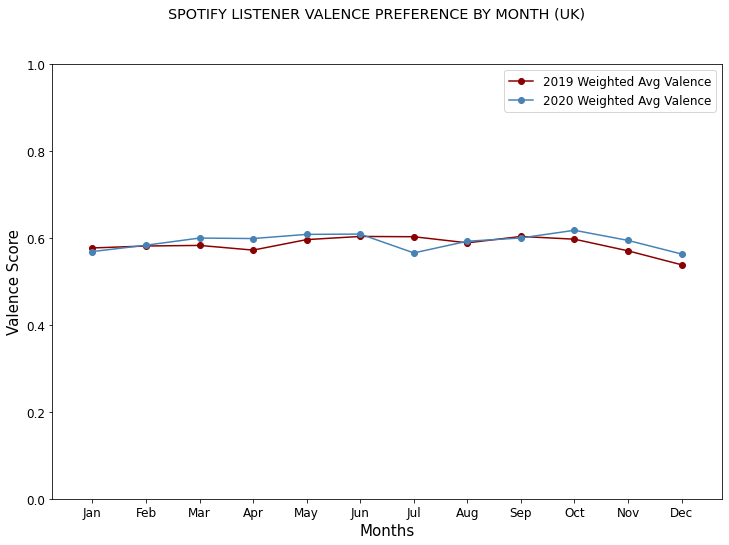

In [24]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (UK)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [26]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'United Kingdom']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932


In [27]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-27-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,


In [28]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,1
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2


In [29]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,2.0
1,2,59.0
2,3,38754.0
3,4,139956.0
4,5,78768.0
5,6,27677.0
6,7,19577.0
7,8,33290.0
8,9,117765.0
9,10,558947.0


In [32]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,2.0
1,2,59.0
2,3,38754.0
3,4,139956.0
4,5,78768.0
5,6,27677.0
6,7,19577.0
7,8,33290.0
8,9,117765.0
9,10,558947.0


In [33]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,1,0.568496,2.0
1,2,0.583145,59.0
2,3,0.599565,38754.0
3,4,0.598433,139956.0
4,5,0.608054,78768.0
5,6,0.608698,27677.0
6,7,0.565437,19577.0
7,8,0.592256,33290.0
8,9,0.599766,117765.0
9,10,0.617437,558947.0


In [34]:
# Add a new cases per million column

country_polulation = 5002100  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,1,0.568496,2.0,0.399832
1,2,0.583145,59.0,11.795046
2,3,0.599565,38754.0,7747.546031
3,4,0.598433,139956.0,27979.448632
4,5,0.608054,78768.0,15746.986266
5,6,0.608698,27677.0,5533.076108
6,7,0.565437,19577.0,3913.756222
7,8,0.592256,33290.0,6655.204814
8,9,0.599766,117765.0,23543.111893
9,10,0.617437,558947.0,111742.468163


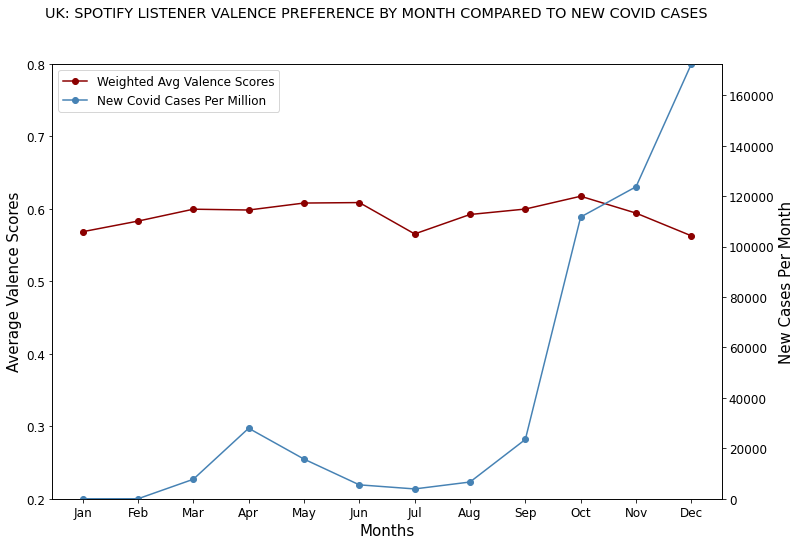

In [35]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('UK: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [36]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

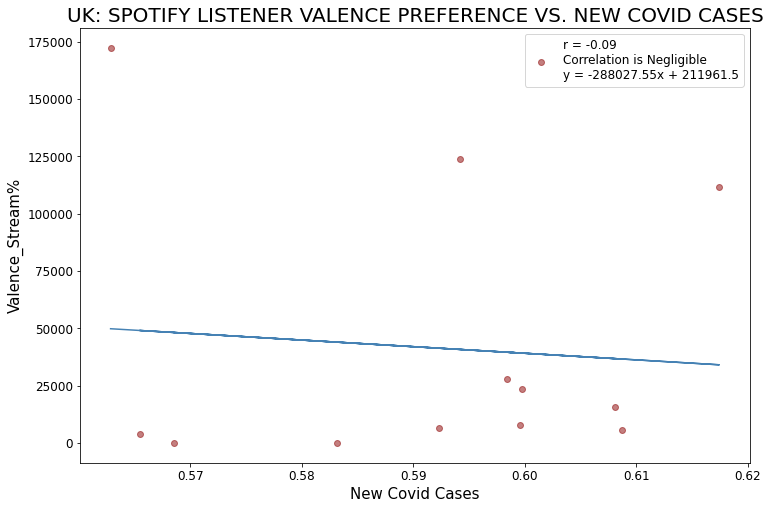

In [38]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('UK: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()